In [2]:
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

from src.data.tiny_digits_5x3 import load_tiny_digits_vectors
from src.viz.digits import show_digit_vector, show_filters_vectors
from src.nn.manual_feature_net import ManualFeatureNet
from src.nn.mlp import init_mlp, predict_single
from src.nn.train import train_mlp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

## The Neuron (Perceptron)

The basic unit of a neural network is a **neuron**, also called a **perceptron**.

The basic unit of a neural network is a **neuron**, also called a **perceptron**.

Conceptually, a neuron receives **multiple activation signals** through its **dendrites**.  
These signals can originate from sensory inputs or from other neurons in the network.

The neuron then:
- Collects all incoming activations
- Combines them into a **single cumulative activation**
- Passes this value further through its **axon** to the next part of the system

At this stage, the process is shown only **abstractly**, without any mathematical details.

<p align="center">
  <img src="../assets/neuron-axon-dendrites-labeled.png" style="width:80%;">
</p>

## Neuron as a Mathematical Function

Now we can describe this same process **mathematically**.

Each incoming activation $ \ x_i $ is associated with a **weight** $ \ w_i $, which determines how strongly that input influences the neuron.  
The neuron computes a **weighted sum** of all inputs and adds a **bias** term $ \ b $.

This operation is expressed as:

$$
\text{activation} = \sum_{i=1}^{n} x_i w_i + b
$$

This formula is explicitly illustrated in the diagram below, mapped directly onto the structure of the neuron.

<p align="center">
  <img src="../assets/neuron-computes-activation.png" style="width:100%;">
</p>

The inputs to a neuron may be any data that can be expressed as continuous numerical variables; for example, pixel intensity values in an image. For simplicity of neural net interpretation, let's say we want to build a neural network capable to recogize 5x3 digits.

## Pattern Detection with Neurons

The inputs to a neuron can be any data that can be represented as numerical values — for example, **pixel intensities** in an image.

For simplicity, consider a toy computer vision task: recognizing digits represented as **5×3 binary images**.

<p align="center">
    <img src="../assets/computer-vision-neuron.png" style="width:40%;">
</p>

Each pixel becomes one input to a neuron. By carefully choosing the weights, a neuron can be made sensitive to **specific spatial patterns** in the image.

---


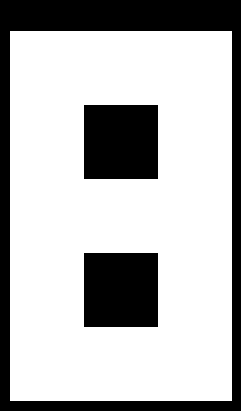

In [3]:
X, y, meta = load_tiny_digits_vectors()
H, W = meta["height"], meta["width"]
input_size = meta["input_size"]

show_digit_vector(X[8], H, W, title="Digit 8")

## Neurons as Pattern Detectors

If we set the weights of some inputs to zero and others to one, the neuron effectively **ignores certain pixels and focuses only on a selected region** of the image.

This allows a neuron to act as a **pattern detector**.

### Labels:
- ⬛➡️ input multiplied by 0 (weight = 0, pixel ignored)
- 🟩➡️ input multiplied by 1 (weight = 1, pixel contributes)

<p align="center">
    <img src="../assets/pattern-recognition-neuron.png" style="width:100%;">
</p>

---

## Intuitive Interpretation of the Three Neurons

### 🧠 Neuron 1 — Left-Side Pixels

This neuron considers **only the pixels on the left side** of the image.

- Digits like **6, 8, 0** strongly activate this neuron because they contain many left-side pixels
- Digits such as **2, 3, 4, 5, 9** activate it moderately
- Digit **7** activates it weakly
- Digit **1** does not activate it at all, because it has no left-side pixels in the 5×3 representation

This neuron detects the pattern:  
> *“Is there significant structure on the left side of the image?”*

---

### 🧠 Neuron 2 — Right-Side Pixels

This neuron focuses only on the **right side** of the image.

- Strong activation: **1, 3, 4, 7, 8, 9, 0**
- Moderate activation: **2, 5, 6**

This neuron answers a different question:  
> *“Is there significant structure on the right side of the image?”*

---

### 🧠 Neuron 3 — Horizontal Bars

This neuron responds to **horizontal line patterns**.

- Strong activation: **2, 3, 5, 6, 8, 9, 0** (three horizontal bars)
- Weak activation: **1, 4, 7**

This neuron detects:  
> *“Does the image contain horizontal strokes?”*

---

## How Multiple Neurons Create Understanding

Individually, each neuron detects only a **simple pattern**.  
Together, they form a **distributed representation** of the digit.

Consider three digits: **0, 8, and 1**

- **8** strongly activates *all three neurons*  
  → highest combined activation
- **0** strongly activates the horizontal-bar neuron and moderately activates the side-pixel neurons  
  → moderate combined activation
- **1** strongly activates only the right-side neuron  
  → lowest combined activation

The described logic is exactly a kind of task performed by neurons in the second layer, who's inputs are activation outputs of neurons from the first layer. Mathenatically, it would look like this:

<p align="center">
    <img src="../assets/neural-network-as-equation.png" style="width:100%;">
</p>

Although no single neuron recognizes a digit by itself,  
the **combination of activations** makes the digits distinguishable.

This is the key idea:
> Neural networks do not recognize patterns with single neurons —  
> they recognize patterns through **coordinated activity of many simple neurons**.

## My struggle
The following section represent my struggle to manualy program the NN to correctly classify 10 digits. Spoiler - it was a great waste of time and the best accuracy reached was 90%, what is far not good for such a trivial task! Also, I used 7 neurons in the hidden layer for this task, what is almost equal to the number of unique classes in a given problem!

Manual predictions:
y | ŷ
-----
0 | 0
1 | 1
2 | 8
3 | 3
4 | 4
5 | 5
6 | 6
7 | 7
8 | 8
9 | 9


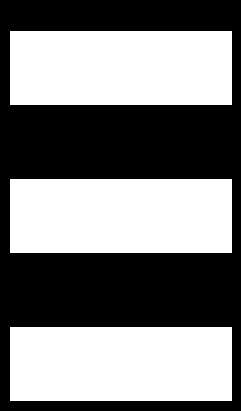

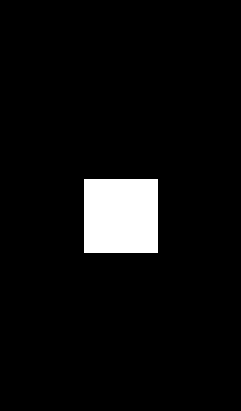

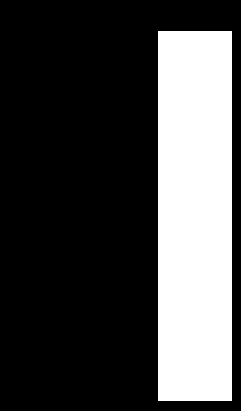

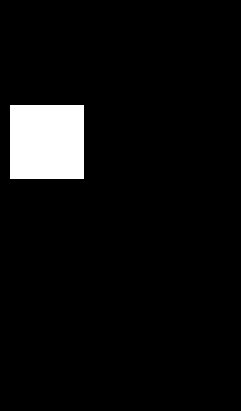

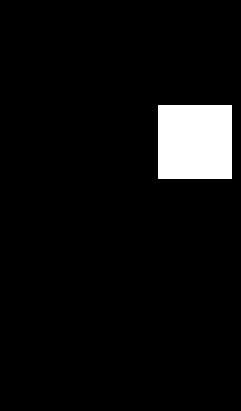

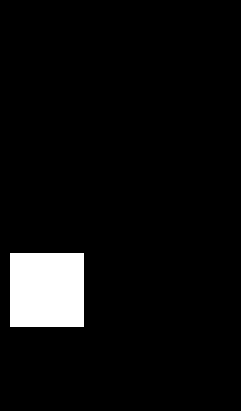

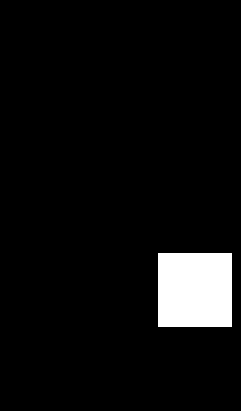

In [9]:
manual = ManualFeatureNet()

print("Manual predictions:")
print("y | ŷ")
print("-----")
for i in range(len(X)):
    print(y[i], "|", manual.predict(X[i]))

# Visualize handcrafted "feature neurons"
hidden_masks = manual.hidden_masks
show_filters_vectors(manual.W_hand, H, W, titles=[f"mask {i}" for i in range(manual.W_hand.shape[0])])

## Why Manual Pattern Design Does Not Scale

Manually designing neurons like this is feasible only for very small and artificial problems.

As soon as:
- the number of classes increases,
- image resolution grows,
- or real-world variability is introduced (e.g. handwritten digits),

manually defining patterns becomes impractical or impossible.

This leads to the central question:

**Instead of designing patterns by hand, how can a neural network automatically discover the right weights to solve a task?**

The answer lies in **learning** — adjusting weights using data and optimization algorithms.

# Learned MLP

In [20]:
params_old = init_mlp(input_size=H*W, hidden_size=5, output_size=10, seed=42)
print("Before training:")
print("y | ŷ")
print("-----")
for i in range(len(X)):
    print(y[i], "|", predict_single(X[i], params_old))

Before training:
y | ŷ
-----
0 | 8
1 | 9
2 | 8
3 | 8
4 | 0
5 | 0
6 | 0
7 | 9
8 | 8
9 | 8


In [21]:
params_learned = train_mlp(X, y, params_old, learning_rate=0.1, epochs=300, print_every=100)

[MLP] Epoch    1 | loss=2.3004 | acc=10.0%
[MLP] Epoch  100 | loss=2.0543 | acc=40.0%
[MLP] Epoch  200 | loss=1.4922 | acc=70.0%
[MLP] Epoch  300 | loss=0.8085 | acc=100.0%


In [22]:
print("After training:")
print("y | ŷ")
print("-----")
for i in range(len(X)):
    print(y[i], "|", predict_single(X[i], params_learned))

After training:
y | ŷ
-----
0 | 0
1 | 1
2 | 2
3 | 3
4 | 4
5 | 5
6 | 6
7 | 7
8 | 8
9 | 9


# 4) Interpreting learned patterns (weights as "filters")
### Each hidden unit has weights shaped (H,W).
Visualizing them revelas that they doesn't look much human interpretable. But the fact is - gradient descent was able to find complex enough pattern relations to reach 100% accuracy with only 5 neurons in the hidden layer, and it took a few miliseconds to find optimal values!

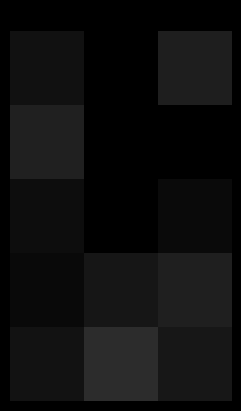

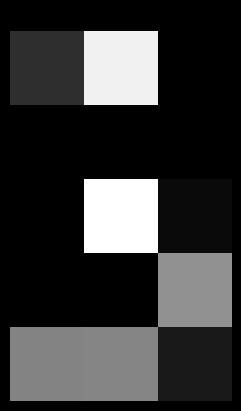

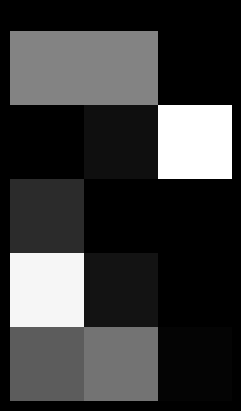

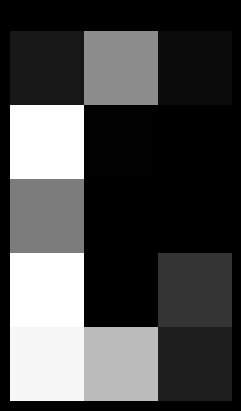

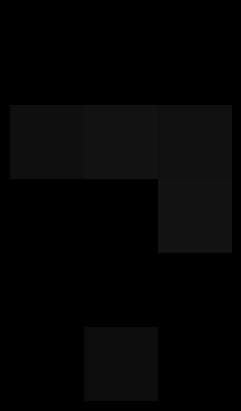

In [24]:
show_filters_vectors(params_learned["W1"], H, W, titles=[f"learned {i}" for i in range(params_learned["W1"].shape[0])])